In [1]:
import os
from collections import Counter, OrderedDict
import numpy as np
from operator import itemgetter
import matplotlib.pyplot as plt
from astropy.table import Table
import schwimmbad
from cesium.time_series import TimeSeries
import cesium.featurize as featurize
from tqdm import tnrange, tqdm_notebook
import sklearn 
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
pbmap = OrderedDict([(0,'u'), (1,'g'), (2,'r'), (3,'i'), (4, 'z'), (5, 'y')])

# it also helps to have passbands associated with a color
pbcols = OrderedDict([(0,'blueviolet'), (1,'green'), (2,'red'),\
                      (3,'orange'), (4, 'black'), (5, 'brown')])

pbnames = list(pbmap.values())

In [3]:
datadir = 'input/'
metafilename = f'{datadir}/training_set_metadata.csv'
metadata = Table.read(metafilename, format='csv')
nobjects = len(metadata)
metadata

object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64
615,349.046051,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,nan,0.017,92
713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
730,33.574219,-6.579593,170.455585,-61.548219,1,0.232,0.2262,0.0157,40.2561,0.021,42
745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90
1227,35.683594,-5.379379,171.992947,-59.253501,1,0.0,0.0,0.0,nan,0.02,65
1598,347.84671,-64.760857,318.929827,-49.143596,1,0.1352,0.182,0.0304,39.7279,0.019,90
1632,348.595886,-63.07262,320.023289,-50.71306,1,0.6857,0.7014,0.01,43.1524,0.021,42
1920,149.414062,3.433834,234.919132,42.24555,1,0.3088,0.3229,0.336,41.1401,0.027,90


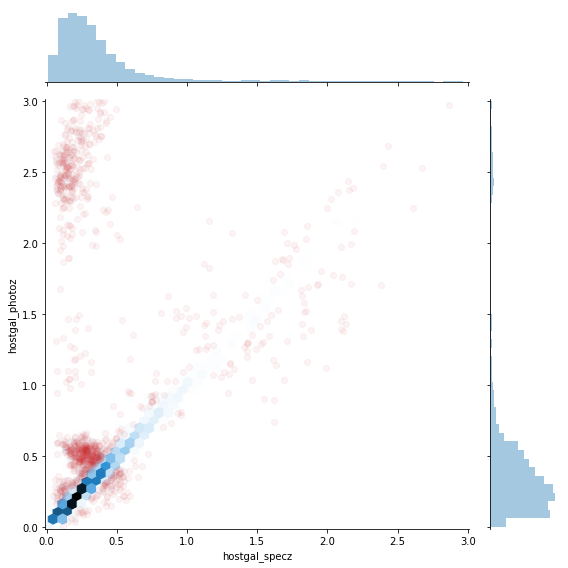

In [4]:
extragal = metadata['hostgal_specz'] != 0.
g = sns.jointplot(metadata['hostgal_specz'][extragal],\
              metadata['hostgal_photoz'][extragal], kind='hex',\
                  xlim=(-0.01, 3.01), ylim=(-0.01,3.01), height=8)

outliers = np.abs(metadata['hostgal_specz'] - metadata['hostgal_photoz']) > 0.1
fig = g.fig
fig.axes[0].scatter(metadata['hostgal_specz'][outliers],\
                    metadata['hostgal_photoz'][outliers], color='C3', alpha=0.05)
fig.tight_layout()

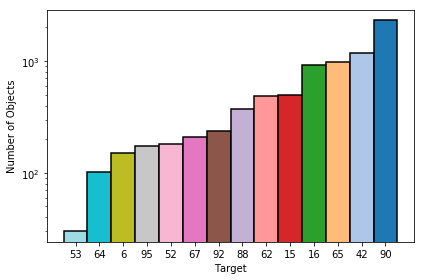

In [5]:

counts = Counter(metadata['target'])
labels, values = zip(*sorted(counts.items(), key=itemgetter(1)))
fig, ax = plt.subplots()

cmap = plt.cm.tab20
nlines = len(labels)
classcolor =  list(cmap(np.linspace(0,1,nlines)))[::-1]

# we'll create a mapping between class and color
classcolmap = dict(zip(labels, classcolor))

indexes = np.arange(nlines)
width = 1
ax.bar(indexes, values, width, edgecolor='k',\
       linewidth=1.5, tick_label=labels, log=True, color=classcolor)
ax.set_xlabel('Target')
ax.set_ylabel('Number of Objects')
fig.tight_layout()

In [6]:

lcfilename = os.path.join(datadir, "training_set.csv")
lcdata = Table.read(lcfilename, format='csv')
lcdata

object_id,mjd,passband,flux,flux_err,detected
int64,float64,int64,float64,float64,int64
615,59750.4229,2,-544.810303,3.622952,1
615,59750.4306,1,-816.434326,5.55337,1
615,59750.4383,3,-471.385529,3.801213,1
615,59750.445,4,-388.984985,11.395031,1
615,59752.407,2,-681.858887,4.041204,1
615,59752.4147,1,-1061.457031,6.472994,1
615,59752.4224,3,-524.95459,3.552751,1
615,59752.4334,4,-393.480225,3.599346,1
615,59752.4435,5,-355.88678,10.421921,1


In [7]:

tsdict = OrderedDict()
for i in range(nobjects):
    row = metadata[i]
    thisid = row['object_id']
    target = row['target']
    
    meta = {'z':row['hostgal_photoz'],\
            'zerr':row['hostgal_photoz_err'],\
            'mwebv':row['mwebv']}
    
    ind = (lcdata['object_id'] == thisid)
    thislc = lcdata[ind]

    pbind = [(thislc['passband'] == pb) for pb in pbmap]
    t = [thislc['mjd'][mask].data for mask in pbind ]
    m = [thislc['flux'][mask].data for mask in pbind ]
    e = [thislc['flux_err'][mask].data for mask in pbind ]

    tsdict[thisid] = TimeSeries(t=t, m=m, e=e,\
                        label=target, name=thisid, meta_features=meta,\
                        channel_names=pbnames )
    
del lcdata

In [8]:
features_to_use = ["amplitude",
                   "percent_beyond_1_std",
                   "maximum",
                   "max_slope",
                   "median",
                   "median_absolute_deviation",
                   "percent_close_to_median",
                   "minimum",
                   "skew",
                   "std",
                   "weighted_average"]

In [9]:

# we'll turn off warnings for a bit, because numpy can be whiny. 
import warnings
warnings.simplefilter('ignore')

In [10]:
def worker(tsobj):
    global features_to_use
    thisfeats = featurize.featurize_single_ts(tsobj,\
    features_to_use=features_to_use,
    raise_exceptions=False)
    return thisfeats

In [11]:
featurefile = f'{datadir}/plasticc_featuretable.npz'
if os.path.exists(featurefile):
    featuretable, _ = featurize.load_featureset(featurefile)
else:
    features_list = []
    with tqdm_notebook(total=nobjects, desc="Computing Features") as pbar:
        with schwimmbad.MultiPool() as pool:  
            results = pool.imap(worker, list(tsdict.values()))
            for res in results:
                features_list.append(res)
                pbar.update()
            
    featuretable = featurize.assemble_featureset(features_list=features_list,\
                              time_series=tsdict.values())
    featurize.save_featureset(fset=featuretable, path=featurefile)

In [12]:
old_names = featuretable.columns.values
new_names = ['{}_{}'.format(x, pbmap.get(y,'meta')) for x,y in old_names]
cols = [featuretable[col] for col in old_names]
allfeats = Table(cols, names=new_names)
del featuretable

In [13]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
splits = list(splitter.split(allfeats, metadata['target']))[0]
train_ind, test_ind = splits

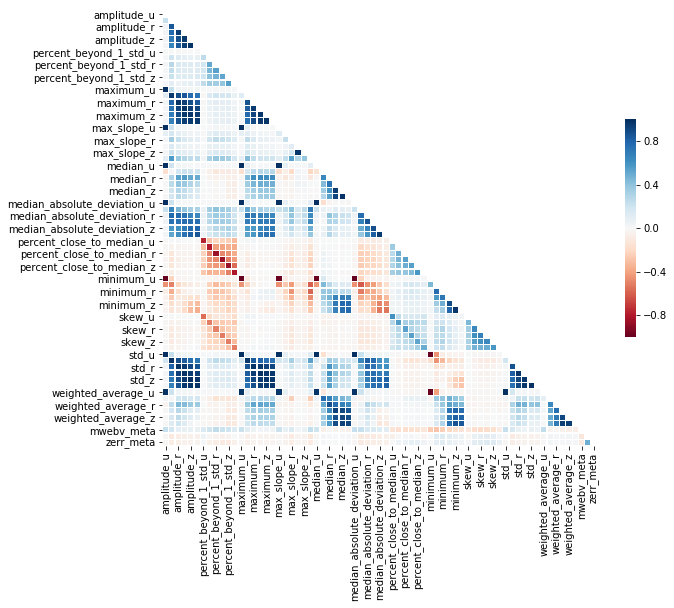

In [14]:

corr = allfeats.to_pandas().corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
corr_plot = sns.heatmap(corr, mask=mask, cmap='RdBu', center=0,
                square=True, linewidths=.2, cbar_kws={"shrink": .5})

In [15]:
Xtrain = np.array(allfeats[train_ind].as_array().tolist())
Ytrain = np.array(metadata['target'][train_ind].tolist())

Xtest  = np.array(allfeats[test_ind].as_array().tolist())
Ytest  = np.array(metadata['target'][test_ind].tolist())

In [16]:
ncols = len(new_names)
npca  = (ncols  - 3)//len(pbnames)  + 3

In [17]:

pca = PCA(n_components=npca, whiten=True, svd_solver="full", random_state=42)
Xtrain_pca = pca.fit_transform(Xtrain)
Xtest_pca = pca.transform(Xtest)

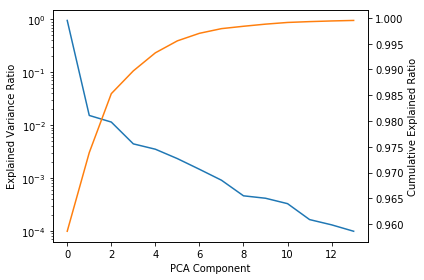

In [18]:
fig, ax = plt.subplots()
ax.plot(np.arange(npca), pca.explained_variance_ratio_, color='C0')
ax2 = ax.twinx()
ax2.plot(np.arange(npca), np.cumsum(pca.explained_variance_ratio_), color='C1')
ax.set_yscale('log')
ax.set_xlabel('PCA Component')
ax.set_ylabel('Explained Variance Ratio')
ax2.set_ylabel('Cumulative Explained Ratio')
fig.tight_layout()

In [19]:
clf = RandomForestClassifier(n_estimators=200, criterion='gini',\
                       oob_score=True, n_jobs=-1, random_state=42,\
                      verbose=1, class_weight='balanced', max_features='sqrt')

In [20]:
clf.fit(Xtrain_pca, Ytrain)
Ypred = clf.predict(Xtest_pca)

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished


In [21]:
cm = confusion_matrix(Ytest, Ypred, labels=labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
annot = np.around(cm, 2)

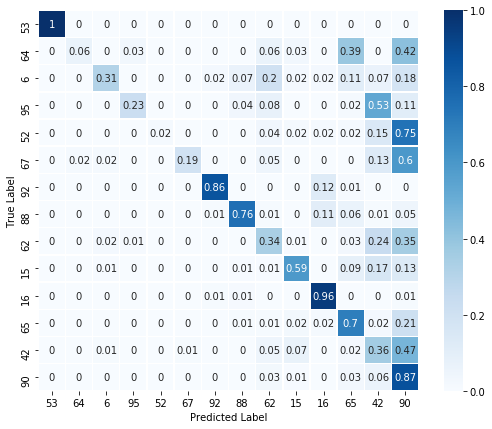

In [22]:
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, cmap='Blues', annot=annot, lw=0.5)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_aspect('equal')